# SpikeInterface Tutorial 


This tutorial covers the basics of using SpikeInterface for extracellular analysis and spike sorting comparisonusing the `spikeinterface` from the SpikeInterface github organization and `MountainSort4`. 

`spikeinterface` wraps 5 subpackages: `spikeextractors`, `spikesorters`, `spiketoolkit`, `spikecomparison`, and `spikewidgets`. Specifically:

- loading the data with spikeextractors package
- preprocess the signals
- run a popular spike sorting algorithm with different parameters
- curate the spike sorting output using 1) quality metrics (automatic) - 2) [Phy](https://github.com/cortex-lab/phy) 
(manual)


## Installation

`pip install spikeinterface` - whole spike interface package

`pip install ml_ms4alg` - MountainSort4 installation

You can also try creating a new `spiketutorial` conda environment using conda as indicated [here](https://github.com/SpikeInterface/spiketutorials/blob/master/NWB_Developer_Breakout_Session_Sep2020/SpikeInterface_Tutorial.ipynb)

In addition, you need to install [Phy](https://github.com/cortex-lab/phy) for the manual curation step.

`pip install phy --pre --upgrade`

In [ ]:
# Install packages mentioned above

!pip install spikeinterface
!pip install ml_ms4alg
!pip install phy --pre --upgrade

In [1]:
# Importing the modules

import spikeinterface
import spikeinterface.extractors as se 
import spikeinterface.toolkit as st
import spikeinterface.sorters as ss
import spikeinterface.comparison as sc
import spikeinterface.widgets as sw
import matplotlib.pylab as plt
import numpy as np
%matplotlib notebook

### Loading Recording Information

- imports spikeextractors pacakge designed to load and save recorded and sorted data and handle probe information

In [2]:
se.recording_extractor_full_list

[spikeextractors.extractors.mdaextractors.mdaextractors.MdaRecordingExtractor,
 spikeextractors.extractors.mearecextractors.mearecextractors.MEArecRecordingExtractor,
 spikeextractors.extractors.biocamrecordingextractor.biocamrecordingextractor.BiocamRecordingExtractor,
 spikeextractors.extractors.exdirextractors.exdirextractors.ExdirRecordingExtractor,
 spikeextractors.extractors.openephysextractors.openephysextractors.OpenEphysRecordingExtractor,
 spikeextractors.extractors.intanrecordingextractor.intanrecordingextractor.IntanRecordingExtractor,
 spikeextractors.extractors.bindatrecordingextractor.bindatrecordingextractor.BinDatRecordingExtractor,
 spikeextractors.extractors.klustaextractors.klustaextractors.KlustaRecordingExtractor,
 spikeextractors.extractors.kilosortextractors.kilosortextractors.KiloSortRecordingExtractor,
 spikeextractors.extractors.spykingcircusextractors.spykingcircusextractors.SpykingCircusRecordingExtractor,
 spikeextractors.extractors.spikeglxrecordingextrac

In [ ]:
# Load a recording object using the right format recordingextractor specifying file path
# So far used se.NumpyRecordingExtractor specifying timeseries, geometry and sampling frequency

recording = se.MdaRecordingExtractor(folder_path='folder_path')
# recording = se.NumpyRecordingExtractor(timeseries=ts, geom=geom, sampling_frequency=sampling_frequency)

If mat file, open with either h5py.File('folder_path', 'r') or scipy.io.loadmat('folder_path') to get timesries and channel number data as shown in example below which loads 'acc_1_04072016_kurosawacoppola_pre.mat' recording file

In [ ]:
f = h5py.File('../eisi_raw_mat_files/acc_1_04072016_kurosawacoppola_pre.mat', 'r') 
# if above doesn't work due to version of saved mat file, try f = scipy.io('../eisi_raw_mat_files/acc_1_04072016_kurosawacoppola_pre.mat')  
num_channels = f['mat'].shape[0]
ts = np.array(f['mat'])
f.close()

sampling_frequency = 40000  # in Hz
geom = np.zeros((num_channels, 2)) # Geom files using 0 value coordinates for channel, input relative coordinates if known
geom[:, 0] = range(num_channels)
recording = se.NumpyRecordingExtractor(timeseries=ts, geom=geom, sampling_frequency=sampling_frequency)


For this tutorial, we can load an exmaple toy dataset and show how we can use spikeinterface

In [3]:
recording, sorting = se.example_datasets.toy_example(num_channels=4, duration=10, seed=0)

In [4]:
channel_ids = recording.get_channel_ids()
fs = recording.get_sampling_frequency()
num_chan = recording.get_num_channels()
num_frames = recording.get_num_frames()

print(f'Channel ids: {channel_ids}')
print(f'Sampling frequency: {fs}')
print(f'Number of channels: {num_chan}')
print(f'Number of frames: {num_frames}')

Channel ids: [0, 1, 2, 3]
Sampling frequency: 30000.0
Number of channels: 4
Number of frames: 300000


We can plot the timeseries for the recording specifying the start and end time

- Start and end time in seconds (number of frames/ sampling frequency)

<IPython.core.display.Javascript object>


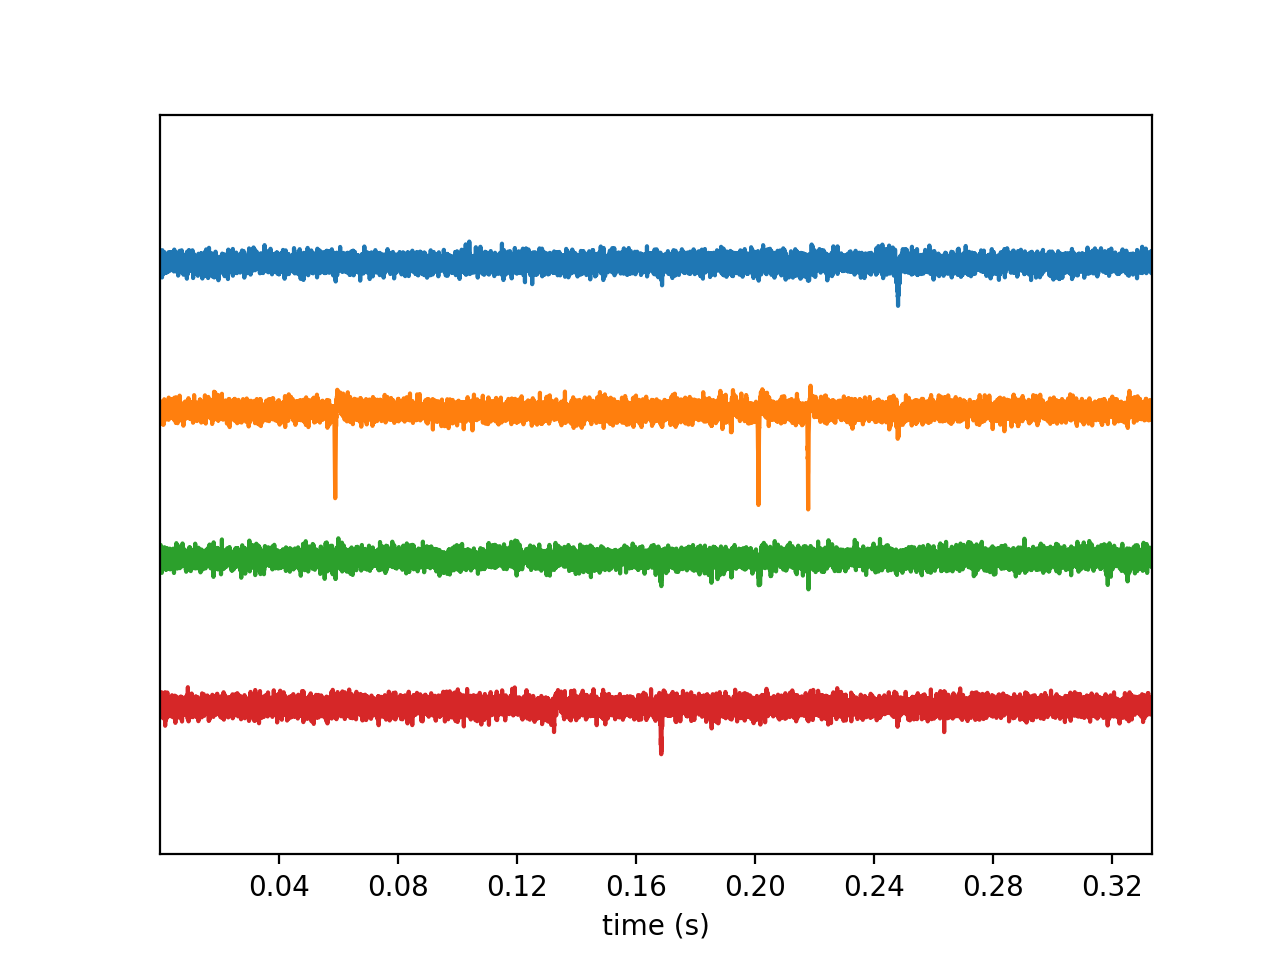

In [5]:
w_ts = sw.plot_timeseries(recording)

## Preprocessing recordings

We can filter the recordings, rereference the signals to remove noise, discard noisy channels, whiten the data, remove stimulation artifacts, etc. (more info [here](https://spiketoolkit.readthedocs.io/en/latest/preprocessing_example.html)).

All preprocessing modules return new `RecordingExtractor` objects that apply the underlying preprocessing function. This allows users to access the preprocessed data in the same way as the raw data.

### Bandpass filtering 
- Performs a lazy filter on the recording extractor traces.  
 
 
Parameters  
- recording: RecordingExtractor - The recording extractor to be filtered.  
- freq_min: int or float - High-pass cutoff frequency.  
- freq_max: int or float - Low-pass cutoff frequency.  
- freq_wid: int or float - Width of the filter (when type is 'fft').  
- filter_type: str - 'fft' or 'butter'. The 'fft' filter uses a kernel in the frequency domain. The 'butter' filter uses scipy butter and filtfilt functions.  
- order: int - Order of the filter (if 'butter').  
- chunk_size: int - The chunk size to be used for the filtering.  
- cache_chunks: bool (default False). - If True then each chunk is cached in memory (in a dict)  
- dtype: dtype - The dtype of the traces  


- Returns filter_recording: BandpassFilterRecording  - The filtered recording extractor object  

<IPython.core.display.Javascript object>


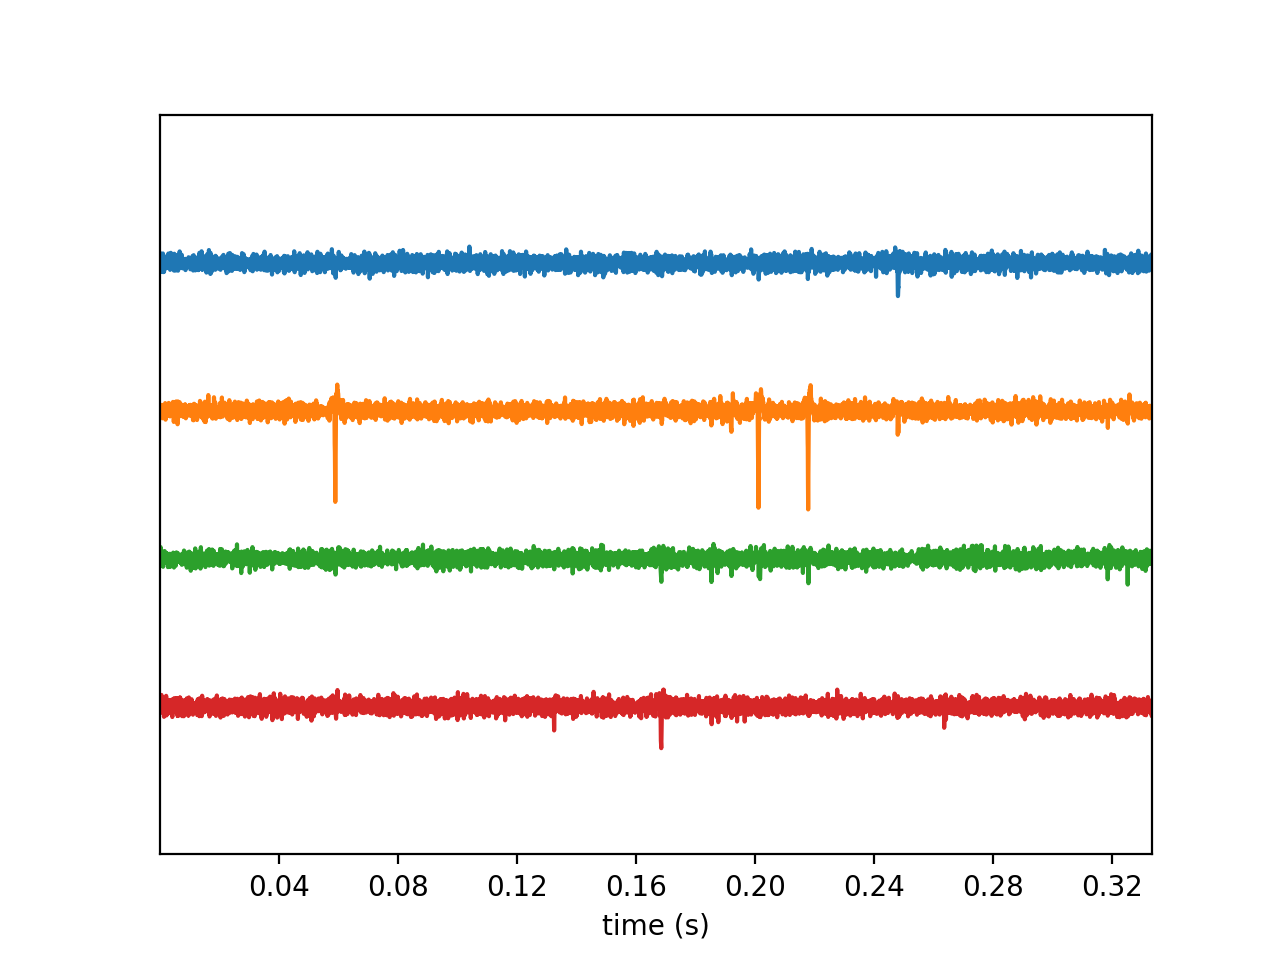

In [9]:
recording_f = st.preprocessing.bandpass_filter(recording, freq_min=300, freq_max=6000)

w = sw.plot_timeseries(recording_f)

# Spike sorting

We can now run spike sorting on the above recording and sort the bandpass filtered recording.

In [6]:
# should list MountainSort4 or prefered sorter
ss.installed_sorters()

['mountainsort4']

In [7]:
ss.get_default_params('mountainsort4')

{'detect_sign': -1,
 'adjacency_radius': -1,
 'freq_min': 300,
 'freq_max': 6000,
 'filter': True,
 'whiten': True,
 'curation': False,
 'num_workers': None,
 'clip_size': 50,
 'detect_threshold': 3,
 'detect_interval': 10,
 'noise_overlap_threshold': 0.15}

In [10]:
default_ms4_params = ss.Mountainsort4Sorter.default_params()
default_ms4_params['detect_threshold'] = 4
default_ms4_params['curation'] = False
default_ms4_params['filter'] = False
output_folder = 'sample_sorted'
sorting = ss.run_mountainsort4(recording_f, output_folder=output_folder,**default_ms4_params)
print('Found', len(sorting_KL.get_unit_ids()), 'units')

Found 9 units


In [8]:
# Or run the sorting directly on the original recording file turning filter on 
default_ms4_params = ss.Mountainsort4Sorter.default_params()
default_ms4_params['detect_threshold'] = 4
default_ms4_params['curation'] = False
default_ms4_params['filter'] = True
output_folder = 'sample_sorted'
sorting = ss.run_mountainsort4(recording, output_folder=output_folder,**default_ms4_params)
print('Found', len(sorting.get_unit_ids()), 'units')

Warning! The recording is already filtered, but Mountainsort4 filter is enabled. You can disable filters by setting 'filter' parameter to False
Found 9 units


In [17]:
print('Units', sorting.get_unit_ids())
# Get unit spike train of the first unit
print('Unit 1 Spike Count: ', len(sorting.get_unit_spike_train(1)), ' with spike train: ', sorting.get_unit_spike_train(1))

Units [1, 2, 3, 4, 5, 6, 7, 8, 9]
Unit 1 Spike Count:  32  with spike train:  [  7439  18070  19459  30936  38678  47965  62666  63116  64195  73329
  79368  80130 131111 131861 132922 136846 139894 157403 163387 171721
 183789 185083 200032 201194 201510 202029 204800 209292 272720 273554
 281816 283123]


<IPython.core.display.Javascript object>


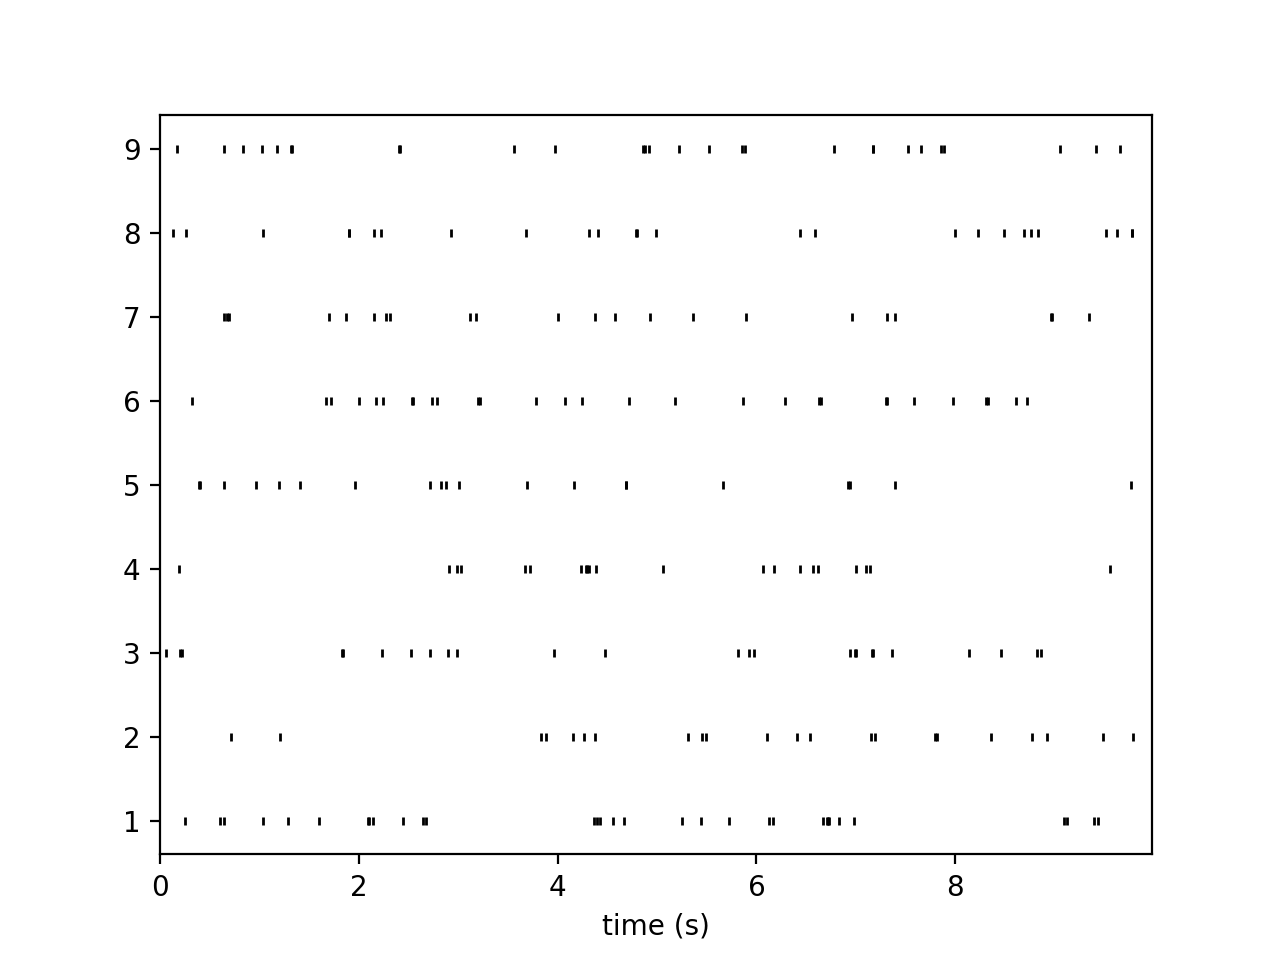

In [15]:
# Plot raster
# sorting, sampling_frequency, unit_ids=None, trange=None, color='k', figure=None, ax=None)
w_rs = sw.plot_rasters(sorting)

## Postprocessing

The `postprocessing` submodule of `spiketoolkit` allow us to extract information from the combination of the recording and sorting extractors. For example, we can extract waveforms, templates, maximum channels and pca scores. In addition, we can also compute waveform features that could be used for further processing, e.g. classyfing excitatory-inhibitory neurons.

To extract the waveforms, we can run:

In [16]:
waveforms = st.postprocessing.get_unit_waveforms(recording, sorting, verbose=True)

Waveform 1/9
Waveform 2/9
Waveform 3/9
Waveform 4/9
Waveform 5/9
Waveform 6/9
Waveform 7/9
Waveform 8/9
Waveform 9/9


In [26]:
for ind, wf in enumerate(waveforms):
    print('Waveform ', ind + 1, ' shape: ', wf.shape)

Waveform  1  shape:  (32, 4, 180)
Waveform  2  shape:  (22, 4, 180)
Waveform  3  shape:  (25, 4, 180)
Waveform  4  shape:  (21, 4, 180)
Waveform  5  shape:  (20, 4, 180)
Waveform  6  shape:  (30, 4, 180)
Waveform  7  shape:  (22, 4, 180)
Waveform  8  shape:  (26, 4, 180)
Waveform  9  shape:  (28, 4, 180)


In [21]:
sorting.get_shared_unit_spike_feature_names()

['waveforms', 'waveforms_idxs']

Similarly, we can get templates, maximum channels, and pca scores. 
Whem these are computed, they are automatically stored in the `SortingExtractor` object, so that they don't need to be recomputed. 

Each waveform is associated with a specific spike, so they are saved as spike *features*:

It can be convenient to only compute a subset of waveforms to speed up the calculation. The `waveform_idxs` property contains the spike indexes associated with the waveforms.

In [24]:
# the spike indexes associated with the waveforms.
print(sorting.get_unit_spike_features(2, 'waveforms_idxs'))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


<IPython.core.display.Javascript object>


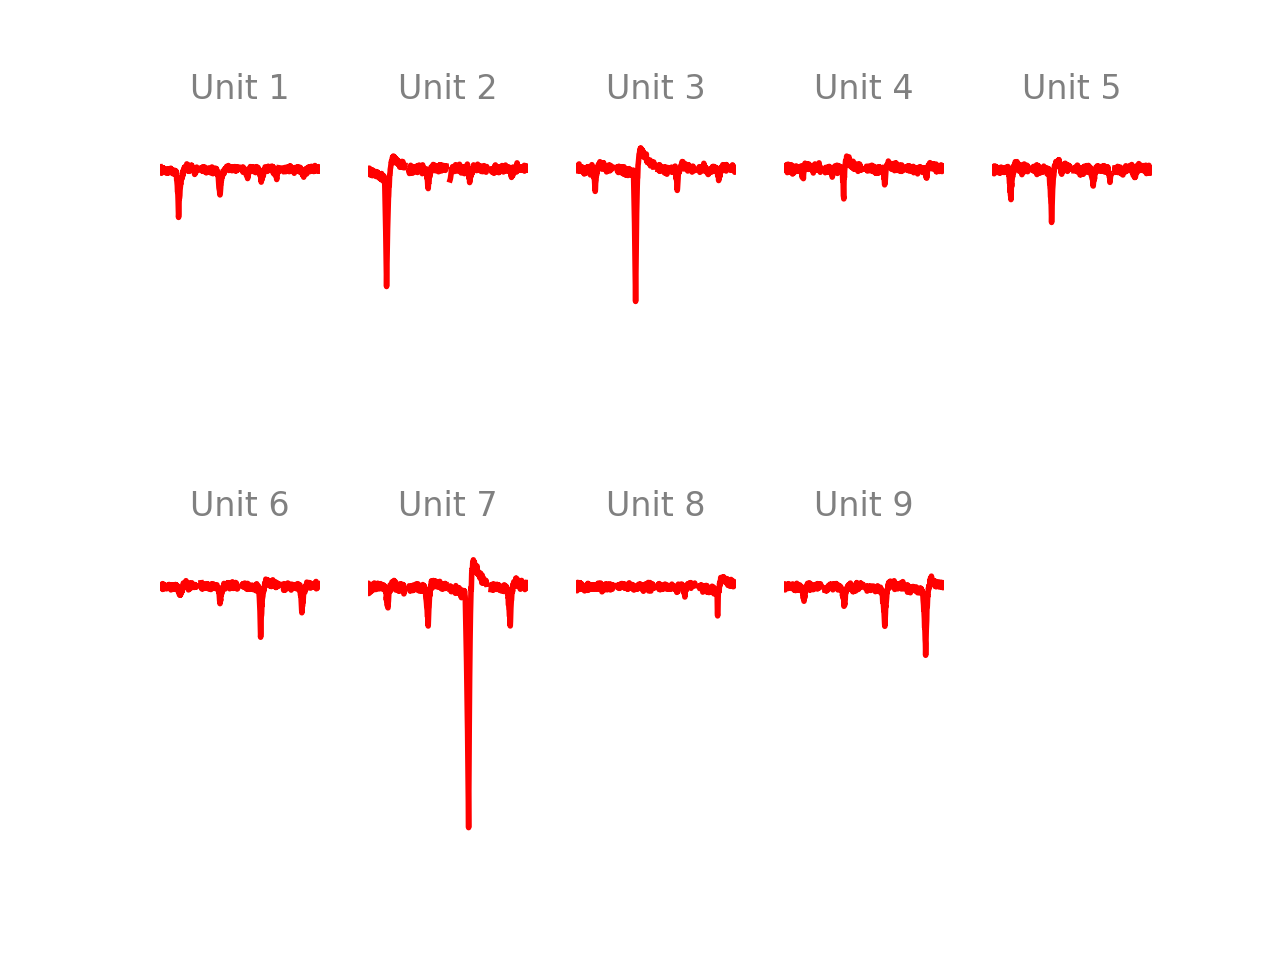

In [28]:
sw.plot_unit_templates(sorting=sorting, recording=recording, color = 'r')

<IPython.core.display.Javascript object>


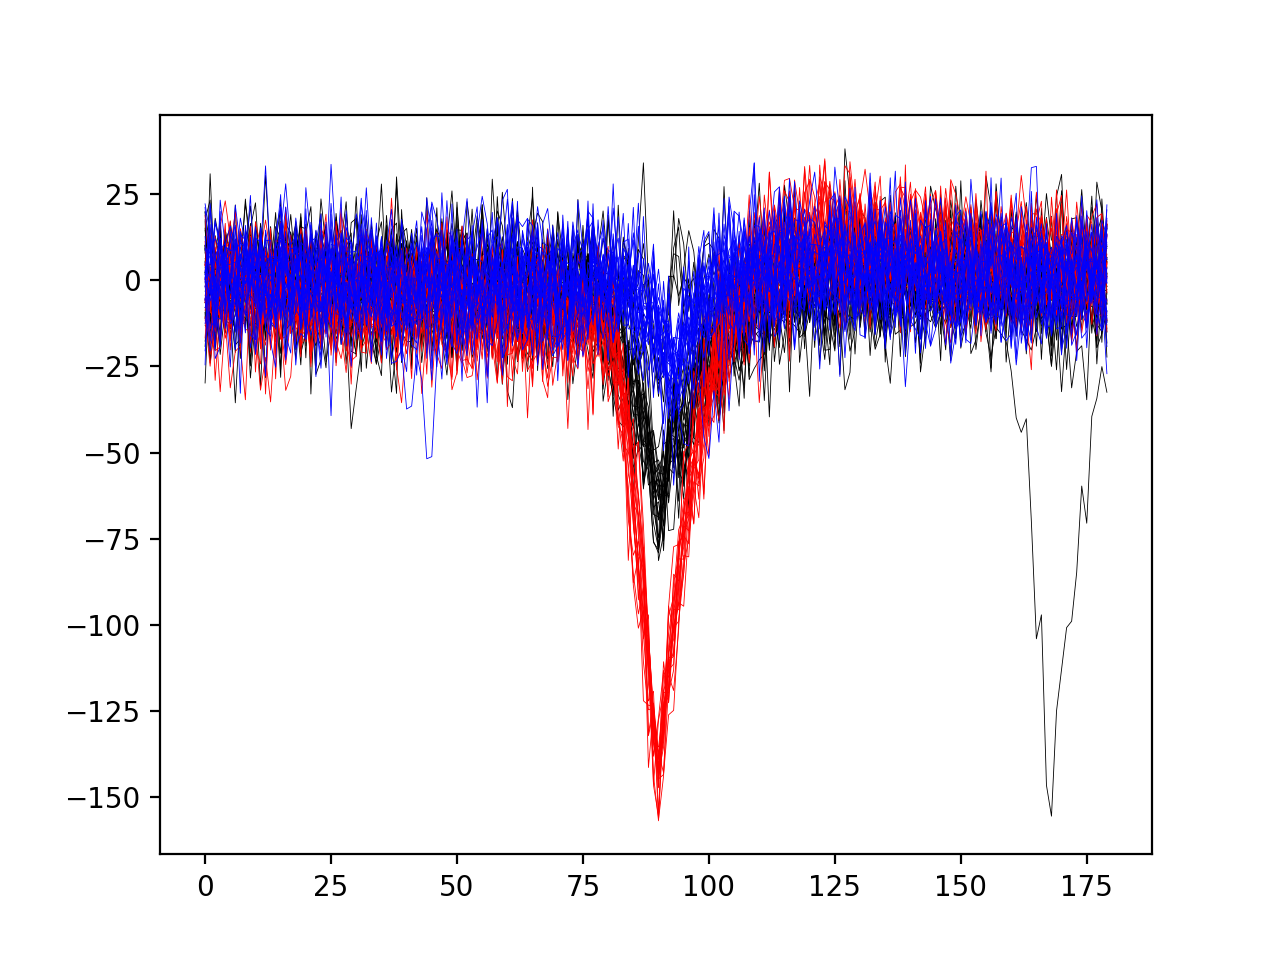

In [40]:
# plotting waveforms of units 0,1,2 on channel 0
fig, ax = plt.subplots()
ax.plot(waveforms[0][:, 0, :].T, color='k', lw=0.3)
ax.plot(waveforms[1][:, 0, :].T, color='r', lw=0.3)
ax.plot(waveforms[2][:, 0, :].T, color='b', lw=0.3)

Similarly to waveforms, templates - average waveforms - can be easily  extracted using the get_unit_templates. When spike trains have  numerous spikes, you can set the max_spikes_per_unit to be extracted.  If waveforms have already been computed and stored as features, those  will be used. Templates can be saved as unit properties.

In [41]:
templates = st.postprocessing.get_unit_templates(recording, sorting, max_spikes_per_unit=200,
                                                 save_as_property=True, verbose=True)

<IPython.core.display.Javascript object>


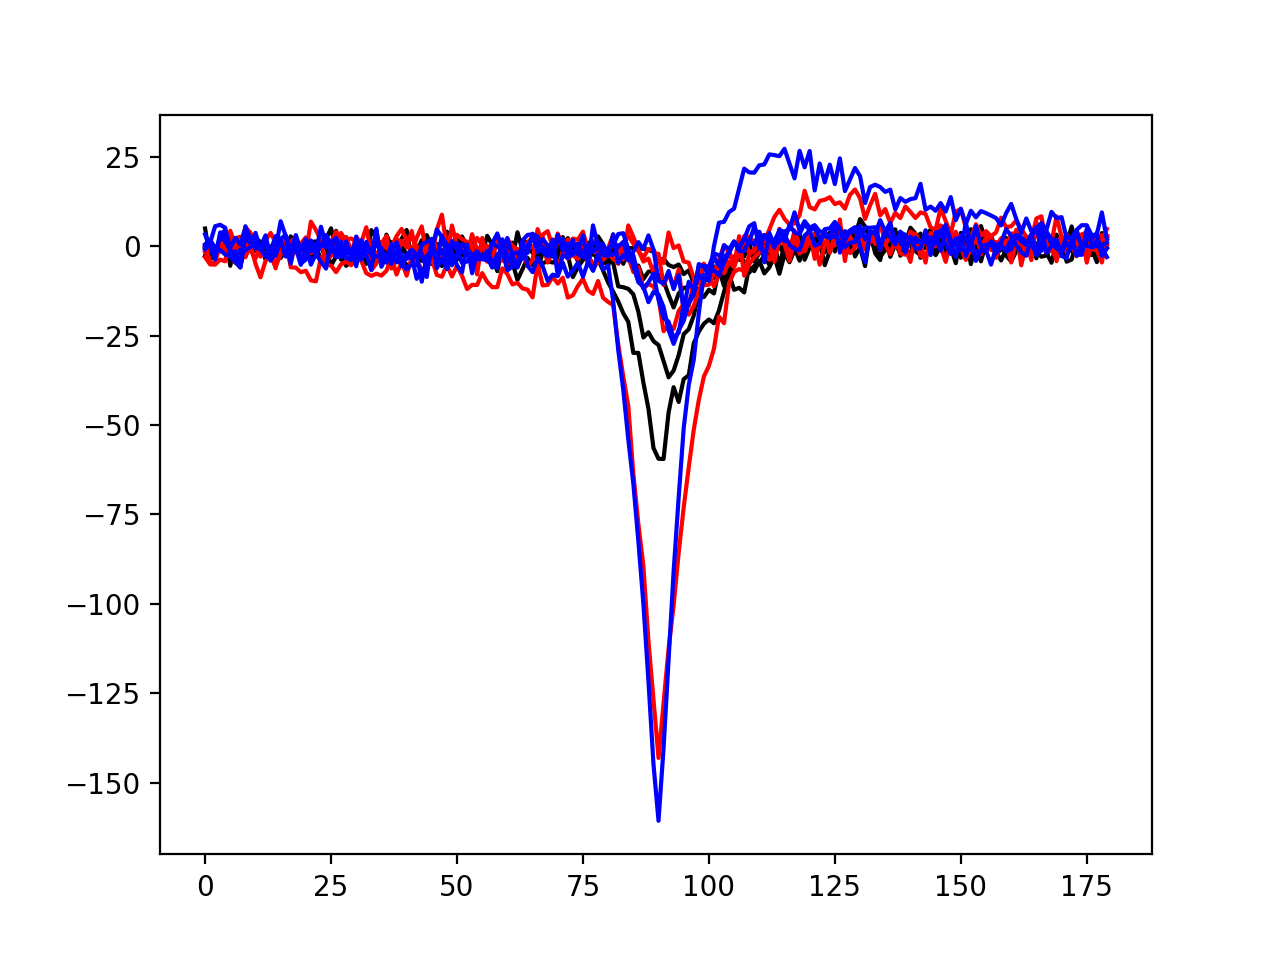

In [43]:
fig, ax = plt.subplots()
ax.plot(templates[0].T, color='k')
ax.plot(templates[1].T, color='r')
ax.plot(templates[2].T, color='b')

In [42]:
max_chan = st.postprocessing.get_unit_max_channels(recording, sorting, save_as_property=True, verbose=True)
print(max_chan)

[0, 0, 1, 1, 1, 2, 2, 3, 3]


For example validating the spike sorting output,  PCA scores can be computed.

Computing waveforms
Fitting PCA of 3 dimensions on 226 waveforms
Projecting waveforms on PC
(32, 4, 3)
(22, 4, 3)
(25, 4, 3)
(21, 4, 3)
(20, 4, 3)
(30, 4, 3)
(22, 4, 3)
(26, 4, 3)
(28, 4, 3)


<IPython.core.display.Javascript object>


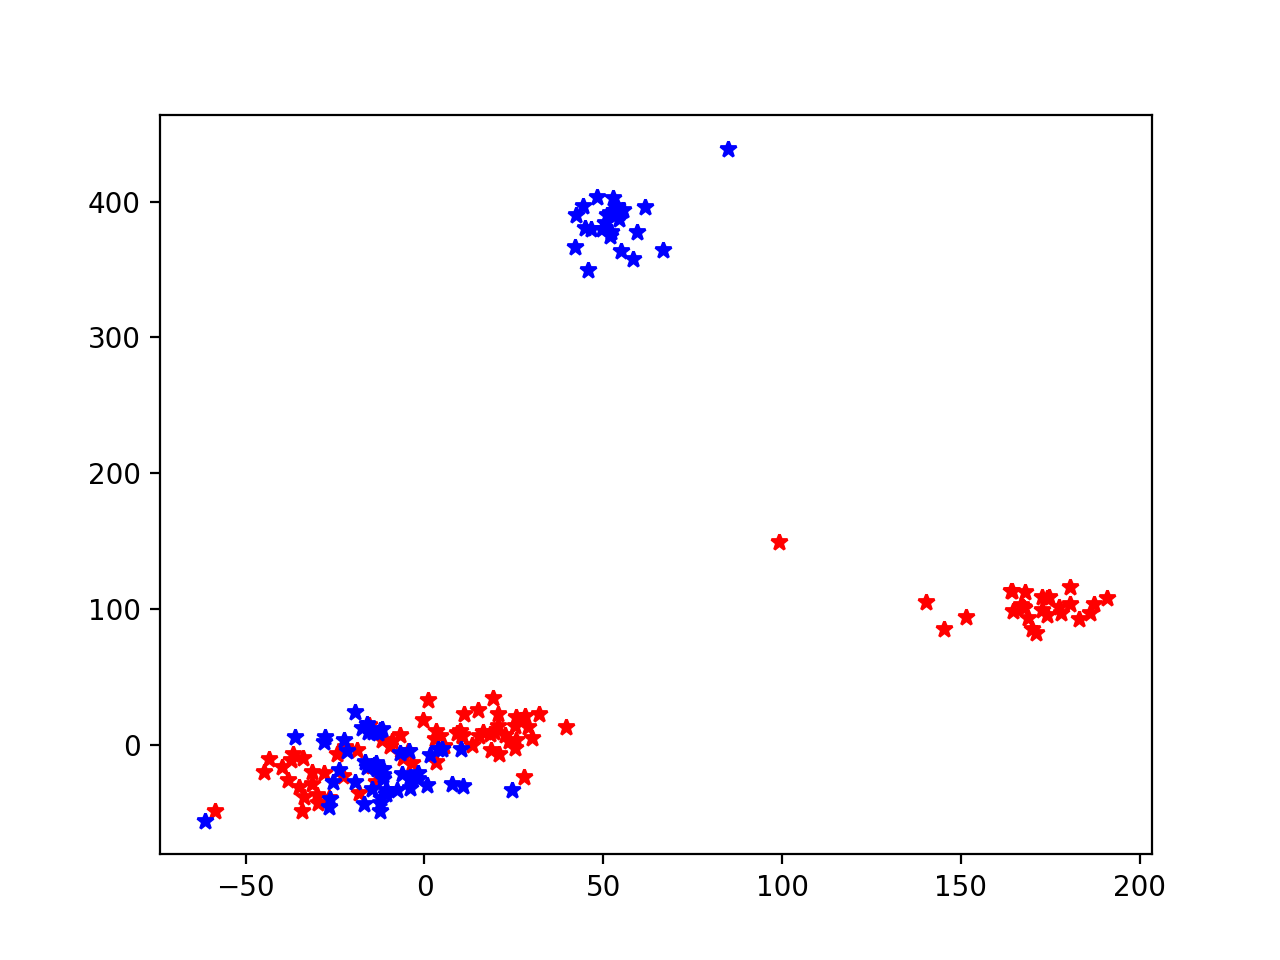

In [44]:
pca_scores = st.postprocessing.compute_unit_pca_scores(recording, sorting, n_comp=3, verbose=True)

for pc in pca_scores:
    print(pc.shape)

fig, ax = plt.subplots()
ax.plot(pca_scores[0][:, 0], pca_scores[0][:, 1], 'r*')
ax.plot(pca_scores[2][:, 0], pca_scores[2][:, 1], 'b*')

### Compute extracellular features

Extracellular features, such as peak to valley duration or full-width half maximum, are important to classify neurons into putative classes (excitatory - inhibitory). For more information about these waveform features, we refer to this [documentation](https://github.com/AllenInstitute/ecephys_spike_sorting/tree/master/ecephys_spike_sorting/modules/mean_waveforms) from the Allen Institute.

The postprocessing module of spiketoolkit allows one to compute several of these features:

In [29]:
st.postprocessing.get_template_features_list()

['peak_to_valley',
 'halfwidth',
 'peak_trough_ratio',
 'repolarization_slope',
 'recovery_slope']

In [30]:
features = st.postprocessing.compute_unit_template_features(recording, sorting, as_dataframe=True, 
                                                            upsampling_factor=10)
display(features)

,peak_to_valley,halfwidth,peak_trough_ratio,repolarization_slope,recovery_slope
1,[0.00132],[0.0003933333333333333],[-0.1369514059222094],[55364.23512648689],[-1803.5135212753637]
2,[0.00129],[0.0003266666666666667],[-0.11152712179963985],[213666.48348533423],[-8690.98242411237]
3,[0.0008433333333333333],[0.00025666666666666665],[-0.17124738302181503],[443364.0264438684],[-12705.721302595606]
4,[0.0004733333333333333],[0.00018333333333333334],[-0.44359723493608094],[167315.3438196635],[-8170.033600356916]
5,[0.0011366666666666667],[0.00029666666666666665],[-0.20664555896993225],[141610.91387346495],[-6337.979425380921]
6,[0.0012233333333333334],[0.00027],[-0.14151533433408908],[89214.51050956371],[-2575.3288871052323]
7,[0.0007966666666666667],[0.00035],[-0.11984915447607923],[653544.0277453804],[-20938.619738228055]
8,[0.0012],[0.00013666666666666666],[-0.35091550063041016],[105011.66357092475],[-6989.970048760432]
9,[0.0009333333333333333],[0.00035666666666666664],[-0.1388751010741255],[170879.03459146898],[-9213.972011965689]


## Validation

The `spiketoolkit` package also provides several functions to compute qualitity metrics about the spike sorting results through the `validation` module. We can compute a subset of metrics using the `compute_quality_metrics` function or compute one at a time. For more information about these waveform features, we refer to this [documentation](https://allensdk.readthedocs.io/en/latest/_static/examples/nb/ecephys_quality_metrics.html) from the Allen Institute.

Let's see what metrics are available:


In [32]:
st.validation.get_quality_metrics_list()

['num_spikes',
 'firing_rate',
 'presence_ratio',
 'isi_violation',
 'amplitude_cutoff',
 'snr',
 'max_drift',
 'cumulative_drift',
 'silhouette_score',
 'isolation_distance',
 'l_ratio',
 'd_prime',
 'nn_hit_rate',
 'nn_miss_rate']

In [34]:
duration = recording.get_num_frames()
isi_violations = st.validation.compute_isi_violations(sorting, duration_in_frames=duration)
print('ISI violations:', isi_violations)

ISI violations: [0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [35]:
quality_metrics = st.validation.compute_quality_metrics(sorting, recording, 
                                                        metric_names=['isi_violation', 'snr'], as_dataframe=True)
display(quality_metrics)

,isi_violation,snr
1,0.0,5.887909
2,0.0,14.155881
3,0.0,15.808986
4,0.0,3.462632
5,0.0,6.462846
6,0.0,6.372214
7,0.0,28.724984
8,0.0,3.530607
9,0.0,8.240482


## Curation
### 1) Manual curation using Phy

To perform manual curation we will export the data to Phy. 

In [48]:
st.postprocessing.export_to_phy(recording, sorting, output_folder='phy', verbose=True, recompute_info=True)

Converting to Phy format
Waveform 1/9
Waveform 2/9
Waveform 3/9
Waveform 4/9
Waveform 5/9
Waveform 6/9
Waveform 7/9
Waveform 8/9
Waveform 9/9
Fitting PCA of 3 dimensions on 226 waveforms
Projecting waveforms on PC
Saving files
Saved phy format to:  /Users/beam/Documents/chang_lab/main/phy
Run:

phy template-gui  /Users/beam/Documents/chang_lab/main/phy/params.py


In [49]:
%%capture --no-display
!phy template-gui phy_IC/params.py

### 2) Automatic curation based on quality metrics

In [51]:
snr_thresh = 5
isi_viol_thresh = 0.5

In [52]:
sorting_auto = st.curation.threshold_isi_violations(sorting_KL, isi_viol_thresh, 'greater', duration)
len(sorting_auto.get_unit_ids())

9

In [54]:
sorting_auto = st.curation.threshold_snrs(sorting_auto, recording, snr_thresh, 'less')
len(sorting_auto.get_unit_ids())

7